# Programmet har til formål at få geocoded apoteker og apoteksåbninger. Dette skal bruges til at skabe konkurrence og forbruger parametre. 

In [168]:
import numpy             as np
import matplotlib.pyplot as plt           #We use it for construction of graphs, both 3D and 2D

import pandas as pd

import json
import os
import requests

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely
from descartes import PolygonPatch
from tqdm import tqdm



import Function


In [176]:
pip install opencage

Note: you may need to restart the kernel to use updated packages.


In [169]:
import os
current_path = os.getcwd()
current_path

'C:\\Users\\nickl\\OneDrive\\Specialet\\Analyser\\Python\\GeoCoding_New\\thesis_2020'

Importering af Excel oversigt over apoteker

In [170]:
url = 'https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/APOTEK_20200109.csv'
exceldata = pd.read_csv(url , error_bad_lines=False)
exceldata = exceldata.dropna(subset=['Adresse', 'PostNr'])
exceldata


,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0
...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0


In [171]:
exceldata_adress = exceldata["Adresse"]
exceldata_postal = exceldata["PostNr"].apply(int)
exceldata["Adresse_v2"] = exceldata["Adresse"] + ', ' + exceldata_postal.astype(str) + ' Denmark'


exceldata_addres_list = list(exceldata["Adresse_v2"])
exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark"
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark"
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark"
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark"
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark"
...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark"
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark"
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark"
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark"


# Geocoding - Using the OpenCage API we get the longtitude and latitude of the adresses


In [178]:

from opencage.geocoder import OpenCageGeocode

key = "5ce774970ad843b1bfebabd2ac5c098f"
geocoder = OpenCageGeocode(key)

url = 'https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/APOTEK_20200109.csv'
exceldata = pd.read_csv(url , error_bad_lines=False)
exceldata = exceldata.dropna(subset=['Adresse', 'PostNr'])

exceldata_adress = exceldata["Adresse"]
exceldata_postal = exceldata["PostNr"].apply(int)
exceldata["Adresse_v2"] = exceldata["Adresse"] + ', ' + exceldata_postal.astype(str) + ' Denmark'


exceldata_addres_list = list(exceldata["Adresse_v2"])


In [8]:
latitudes = []
longitudes = []

for address in exceldata_addres_list:
	result = geocoder.geocode(address, no_annotations="1")

	if result and len(result):
		longitude = result[0]['geometry']['lng']
		latitude = result[0]['geometry']['lat']
	else:
		longitude = "N/A"
		latitude = "N/A"

	latitudes.append(latitude)
	longitudes.append(longitude)

In [7]:
from datetime import datetime
type(exceldata["Startdato"][0])

str

In [21]:
exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaT,NaN,2008.0,NaT
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01


In [26]:
exceldata["latitudes"] = latitudes
exceldata["longitudes"] = longitudes

exceldata_startdato_list = list(exceldata["Startdato"])

#exceldata["dato"]      = datetime.fromisoformat(exceldata_startdato_list[:-1])
exceldata["Stdato"] = pd.to_datetime(exceldata['Startdato'] , errors='coerce')
exceldata["Sldato"] = pd.to_datetime(exceldata['Slutdato'] , errors='coerce')
exceldata["Styear"] = pd.DatetimeIndex(exceldata['Stdato']).year
exceldata["Slyear"] = pd.DatetimeIndex(exceldata['Sldato']).year

exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaT,1966.0,NaN
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaT,NaN,2008.0,NaT,NaT,NaN,NaN
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaT,2016.0,NaN
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaT,2015.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaT,1933.0,NaN
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaT,1936.0,NaN
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaT,1905.0,NaN
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0


In [27]:
exceldata["dummy"] = exceldata["Styear"].where(exceldata["year"] > 2008, 2008)
#for i in range(2009,2010):
#    exceldata["dummy"] = exceldata["year"].where(exceldata["year"] == i, i)

#exceldata["dummy"] = exceldata["year"].where(exceldata["year"] == 2009, 2009)
exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaT,1966.0,NaN
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaT,NaN,2008.0,NaT,NaT,NaN,NaN
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaT,2016.0,NaN
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaT,2015.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaT,1933.0,NaN
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaT,1936.0,NaN
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaT,1905.0,NaN
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0


In [28]:
df=exceldata.reset_index(drop=True)
df
df.to_csv("Apoteker_Geocoded.csv")

In [81]:
import math
exceldata2.Slyear.isnull()


0       True
1       True
2       True
3      False
4       True
       ...  
708     True
709     True
710     True
711    False
712     True
Name: Slyear, Length: 713, dtype: bool

In [86]:
exceldata2 = pd.read_csv(r"C:\Users\Nicklas Lindegaard\Desktop\Speciale\Python\thesis_2020 - midl\Apoteker_Geocoded.csv")
exceldata2["Slyear"] = exceldata2["Slyear"].apply(float) 
exceldata_v2 = exceldata2[(exceldata2.Slyear>2007) | (exceldata2.Slyear.isnull()) ]
exceldata_v2
#df_2008 =  exceldata[(exceldata["dummy"]  == '2008.0')]

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,...,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear
0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,...,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaN,1966.0,NaN
1,1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,...,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaN,NaN,2008.0,NaN,NaN,NaN,NaN
2,2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,...,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaN,2016.0,NaN
3,3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,...,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0
4,4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,...,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaN,2015.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,708,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,...,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaN,1933.0,NaN
709,709,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,...,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaN,1936.0,NaN
710,710,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,...,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaN,1905.0,NaN
711,711,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,...,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0


In [89]:
from tqdm import tqdm
frames_year = {}
for i in range(2008,2021):
    frames_year[str(i)] = exceldata_v2[(exceldata_v2['dummy']  == i)]  # use globals() to store the vars in the global stack


map1 = folium.Map(
    location=[55.656514 , 	12.353695],
    tiles='cartodbpositron',
    zoom_start=12,
)
frames_year['2008'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='blue',).add_to(map1), axis=1)
frames_year['2009'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='red',).add_to(map1), axis=1)
frames_year['2010'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='green',).add_to(map1), axis=1)
frames_year['2011'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='black',).add_to(map1), axis=1)
frames_year['2012'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='cloud',).add_to(map1), axis=1)
frames_year['2013'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='orange',).add_to(map1), axis=1)
frames_year['2014'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='yellow',).add_to(map1), axis=1)
frames_year['2015'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='purple',).add_to(map1), axis=1)
frames_year['2016'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='lightred',).add_to(map1), axis=1)
frames_year['2017'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='lightgreen',).add_to(map1), axis=1)
frames_year['2018'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='gray',).add_to(map1), axis=1)
frames_year['2019'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='pink',).add_to(map1), axis=1)
frames_year['2020'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='lime',).add_to(map1), axis=1)
  
map1

In [90]:
len(frames_year["2016"])+len(frames_year["2017"])+len(frames_year["2018"])+len(frames_year["2019"])

147

In [91]:
len(frames_year["2008"])

442

In [148]:
frames_map2 = {}
frames_map2['2008'] = exceldata_v2[(exceldata_v2['dummy']  == 2008)]
frames_map2['2008>'] = exceldata_v2[(exceldata_v2['dummy']  > 2008)]

map2 = folium.Map(
    location=[55.656514 , 	12.353695],
    tiles='cartodbpositron',
    zoom_start=12,
)

frames_map2['2008'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='blue',).add_to(map2), axis=1)
frames_map2['2008>'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='red',).add_to(map2), axis=1)

map2
#exceldata["dummy_2"] = exceldata["Styear"].where(exceldata["Styear"] > 2008, 2008)

In [149]:
frames_map3 = {}
frames_map3['2008'] = exceldata_v2[(exceldata_v2['dummy']  == 2008) & (exceldata_v2['TypeID'] != 8)]
frames_map3['2008>'] = exceldata_v2[(exceldata_v2['dummy']  > 2008) & (exceldata_v2['TypeID'] != 8)]

map3 = folium.Map(
    location=[55.656514 , 	12.353695],
    tiles='cartodbpositron',
    zoom_start=12,
)

frames_map3['2008'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='blue',).add_to(map3), axis=1)
frames_map3['2008>'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='red',).add_to(map3), axis=1)

map3

# Laver en funktion som har til formål at undersøge hvilket apotek der er tættest på det udvalgte. 

Til at starte med laver jeg en geodataframe, som indeholder de punkter fra overstående koordinater. 

In [234]:
gdf = gpd.GeoDataFrame(exceldata_v2, geometry=gpd.points_from_xy(exceldata_v2.longitudes, exceldata_v2.latitudes))
gdf.to_csv("Main_data_with_geodat.csv")
gdf

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,...,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaN,1966.0,NaN,POINT (12.35370 55.65651),0.000000
1,1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,...,12.355782,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,POINT (12.35578 55.87112),0.214620
2,2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,...,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaN,2016.0,NaN,POINT (14.80230 55.27712),2.477826
3,3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,...,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0,POINT (14.80230 55.27712),2.477826
4,4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,...,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaN,2015.0,NaN,POINT (12.62277 55.66418),0.269187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,708,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,...,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaN,1933.0,NaN,POINT (10.19870 56.16630),2.214472
709,709,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,...,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaN,1936.0,NaN,POINT (10.16477 56.15646),2.245289
710,710,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,...,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaN,1905.0,NaN,POINT (9.51902 56.80211),3.057411
711,711,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,...,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0,POINT (10.04961 55.38131),2.320460


In [136]:
gdf = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Main_data_with_geodat.csv")
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))


In [11]:



#from shapely.ops import nearest_points
# unary union of the gpd2 geomtries 
#exceldata_v3 = exceldata_v2.geometry.unary_union
#def near(point, pts=exceldata_v3):
     # find the nearest point and return the corresponding Place value
#     nearest = exceldata_v2.geometry == nearest_points(point, pts)[1]
 #    return gpd2[nearest].Place.get_values()[0]

#gpd1['Nearest'] = gpd1.apply(lambda row: near(row.geometry), axis=1)
#gpd1

#DENNE FUNKTION KAN BRUGES TIL AT BEREGNE DISTANCE FRA ANDRE APOTEKER. 



In [138]:
gdf = gdf.sort_values(by=['Kommune'])
type( gdf["geometry"])
gdf['test'] = gdf.distance(gdf["geometry"][0])
gdf

,Unnamed: 0,Unnamed: 0.1,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
313,330,330,341-2,København Hamlets Apotek,7,Hamletsgade 2,2200.0,01Jun2009 0:00:00.000,NaN,1084.0,...,12.547708,2009-06-01,2009.0,2009.0,2009-06-01,NaN,2009.0,NaN,POINT (12.54771 55.70309),0.199525
324,342,342,318,København Trekroner Apotek,6,Vigerslev Allé 38,2500.0,01Jan1925 0:00:00.000,NaN,1084.0,...,12.518641,1925-01-01,1925.0,2008.0,1925-01-01,NaN,1925.0,NaN,POINT (12.51864 55.66188),0.165033
460,479,479,197-1,Ryparken Apotek,7,Lyngbyvej 153,2100.0,30Aug2019 0:00:00.000,NaN,1084.0,...,12.556509,2019-08-30,2019.0,2019.0,2019-08-30,NaN,2019.0,NaN,POINT (12.55651 55.71798),0.211925
314,332,332,322,København Husum Apotek,6,Frederikssundsvej 320,2700.0,01Jan1929 0:00:00.000,NaN,1084.0,...,12.472550,1929-01-01,1929.0,2008.0,1929-01-01,NaN,1929.0,NaN,POINT (12.47255 55.71200),0.131168
36,36,36,318-A1,Apoteksudsalg fra Trekroner Apopotek,8,Frugthaven 14,2500.0,NaN,01Jun2012 0:00:00.000,13.0,...,12.500794,NaN,NaN,2008.0,NaN,2012-06-01,NaN,2012.0,POINT (12.50079 55.65074),0.147212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,659,659,172-1,Vrå Apotek,7,Jernbanegade 6,9760.0,01Sep2013 0:00:00.000,NaN,1081.0,...,9.942166,2013-09-01,2013.0,2013.0,2013-09-01,NaN,2013.0,NaN,POINT (9.94217 57.35397),2.949036
210,219,219,356,Hirtshals Apotek,6,Jørgen Fibigersgade 18,9850.0,01Jan1959 0:00:00.000,NaN,1081.0,...,9.959974,1959-01-01,1959.0,2008.0,1959-01-01,NaN,1959.0,NaN,POINT (9.95997 57.59050),3.077367
359,377,377,105-4,Løkken Apotek,7,Jyllandsgade 13,9480.0,NaN,NaN,1081.0,...,9.712002,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,POINT (9.71200 57.36850),3.147927
218,227,227,236,Hjørring Svane Apotek,6,Strømgade 5,9800.0,01Jan1911 0:00:00.000,30Jun2019 0:00:00.000,1081.0,...,9.985751,1911-01-01,1911.0,2008.0,1911-01-01,2019-06-30,1911.0,2019.0,POINT (9.98575 57.46133),2.977336


In [91]:
type(gdf["Kommune"])

#frames_Kommune[str(i)][str(z)] = frames_Kommune[str(i)].distance(frames_Kommune[str(i)]["geometry"][z])                      

pandas.core.series.Series

In [92]:
from math import radians, cos, sin, asin, sqrt

def haversine(cords1,cords2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = cords1.x
    lat1 = cords1.y
    lon2 = cords2.x
    lat2 = cords2.y   
    
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [339]:
print(haversine(frames_Kommune['101.0']['geometry'][0],frames_Kommune['101.0']['geometry'][1]))


4.930733114300334


In [179]:
Kommunekode_list = list(gdf["Kommune"])
frames_Kommune = {}
for i in gdf["Kommune"]:
    frames_Kommune[str(i)] = gdf[(gdf['Kommune']  == i)]  # use globals() to store the vars in the global stack
    frames_Kommune[str(i)].drop(['test'], axis=1)
    frames_Kommune[str(i)].sort_values(by=['ApotekNr'])
    frames_Kommune[str(i)] = frames_Kommune[str(i)].reset_index(drop=True)
    for z in range(len(frames_Kommune[str(i)])):
        result = []
        for x in range(len(frames_Kommune[str(i)])):
            #print(len(frames_Kommune[str(i)]))
            result.append(haversine(frames_Kommune[str(i)]['geometry'][z],frames_Kommune[str(i)]['geometry'][x]))
            #print(len(result))
        frames_Kommune[str(i)][frames_Kommune[str(i)]['Navn'][z]] = result
            
    #frames_Kommune[str(i)][frames_Kommune[str(i)]['Navn'][x]] = haversine(frames_Kommune[str(i)]['geometry'][z],frames_Kommune[str(i)]['geometry'][x])

#frames_Kommune[str(i)].distance(frames_Kommune[str(i)]["geometry"][z])





#range(len(frames_Kommune[str(i)]))

In [180]:
#frames_Kommune['101.0'] = frames_Kommune['101.0'].reset_index(drop=True)
frames_Kommune['860.0']
#frames_Kommune['101.0']

,Unnamed: 0,Unnamed: 0.1,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,...,Slyear,geometry,test,Hjørring Løve Apotek,Hjørring Hjorte Apotek,Sindal Apotek,Vrå Apotek,Hirtshals Apotek,Løkken Apotek,Hjørring Svane Apotek
0,226,226,045,Hjørring Løve Apotek,6,Østergade 7 A,9800.0,01-01-1794 00:00,NaN,1081.0,...,NaN,POINT (9.99494 57.45775),2.967855,0.000000,0.724852,12.314192,11.964981,14.908072,19.636312,0.679092
1,225,225,045-1,Hjørring Hjorte Apotek,7,Frederikshavnsvej 44,9800.0,01Feb2018 0:00:00.000,NaN,1081.0,...,NaN,POINT (10.00609 57.45519),2.957448,0.724852,0.000000,11.691250,11.889265,15.295093,20.077890,1.395045
2,503,503,356-1,Sindal Apotek,7,Vestergade 2 A,9870.0,01Jan2005 0:00:00.000,NaN,1081.0,...,NaN,POINT (10.19943 57.47071),2.816409,12.314192,11.691250,0.000000,20.147253,19.538048,31.320493,12.820820
3,658,658,160,Vrå Apotek,6,Jernbanegade 6,9760.0,01Jan1907 0:00:00.000,31Aug2013 0:00:00.000,1081.0,...,2013.0,POINT (9.94217 57.35397),2.949036,11.964981,11.889265,20.147253,0.000000,26.322590,13.897687,12.220907
4,659,659,172-1,Vrå Apotek,7,Jernbanegade 6,9760.0,01Sep2013 0:00:00.000,NaN,1081.0,...,NaN,POINT (9.94217 57.35397),2.949036,11.964981,11.889265,20.147253,0.000000,26.322590,13.897687,12.220907
5,219,219,356,Hirtshals Apotek,6,Jørgen Fibigersgade 18,9850.0,01Jan1959 0:00:00.000,NaN,1081.0,...,NaN,POINT (9.95997 57.59050),3.077367,14.908072,15.295093,19.538048,26.322590,0.000000,28.793508,14.444443
6,377,377,105-4,Løkken Apotek,7,Jyllandsgade 13,9480.0,NaN,NaN,1081.0,...,NaN,POINT (9.71200 57.36850),3.147927,19.636312,20.077890,31.320493,13.897687,28.793508,0.000000,19.372444
7,227,227,236,Hjørring Svane Apotek,6,Strømgade 5,9800.0,01Jan1911 0:00:00.000,30Jun2019 0:00:00.000,1081.0,...,2019.0,POINT (9.98575 57.46133),2.977336,0.679092,1.395045,12.820820,12.220907,14.444443,19.372444,0.000000


In [202]:
gdf['geometry'].crs = {'init': 'epsg:4326', 'no_defs': True}
gdf

,Unnamed: 0,Unnamed: 0.1,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
313,330,330,341-2,København Hamlets Apotek,7,Hamletsgade 2,2200.0,01Jun2009 0:00:00.000,NaN,1084.0,...,12.547708,2009-06-01,2009.0,2009.0,2009-06-01,NaN,2009.0,NaN,POINT (12.54771 55.70309),0.199525
324,342,342,318,København Trekroner Apotek,6,Vigerslev Allé 38,2500.0,01Jan1925 0:00:00.000,NaN,1084.0,...,12.518641,1925-01-01,1925.0,2008.0,1925-01-01,NaN,1925.0,NaN,POINT (12.51864 55.66188),0.165033
460,479,479,197-1,Ryparken Apotek,7,Lyngbyvej 153,2100.0,30Aug2019 0:00:00.000,NaN,1084.0,...,12.556509,2019-08-30,2019.0,2019.0,2019-08-30,NaN,2019.0,NaN,POINT (12.55651 55.71798),0.211925
314,332,332,322,København Husum Apotek,6,Frederikssundsvej 320,2700.0,01Jan1929 0:00:00.000,NaN,1084.0,...,12.472550,1929-01-01,1929.0,2008.0,1929-01-01,NaN,1929.0,NaN,POINT (12.47255 55.71200),0.131168
36,36,36,318-A1,Apoteksudsalg fra Trekroner Apopotek,8,Frugthaven 14,2500.0,NaN,01Jun2012 0:00:00.000,13.0,...,12.500794,NaN,NaN,2008.0,NaN,2012-06-01,NaN,2012.0,POINT (12.50079 55.65074),0.147212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,659,659,172-1,Vrå Apotek,7,Jernbanegade 6,9760.0,01Sep2013 0:00:00.000,NaN,1081.0,...,9.942166,2013-09-01,2013.0,2013.0,2013-09-01,NaN,2013.0,NaN,POINT (9.94217 57.35397),2.949036
210,219,219,356,Hirtshals Apotek,6,Jørgen Fibigersgade 18,9850.0,01Jan1959 0:00:00.000,NaN,1081.0,...,9.959974,1959-01-01,1959.0,2008.0,1959-01-01,NaN,1959.0,NaN,POINT (9.95997 57.59050),3.077367
359,377,377,105-4,Løkken Apotek,7,Jyllandsgade 13,9480.0,NaN,NaN,1081.0,...,9.712002,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,POINT (9.71200 57.36850),3.147927
218,227,227,236,Hjørring Svane Apotek,6,Strømgade 5,9800.0,01Jan1911 0:00:00.000,30Jun2019 0:00:00.000,1081.0,...,9.985751,1911-01-01,1911.0,2008.0,1911-01-01,2019-06-30,1911.0,2019.0,POINT (9.98575 57.46133),2.977336


In [203]:
gdf['geometry_new'] = gdf['geometry'].to_crs(epsg = 3035)
gdf['geometry_detail'] = gdf['geometry'].to_crs(epsg = 23032)
gdf


ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

In [53]:
Kommunekode_list = list(gdf["Kommune"])
frames_Kommune = {}
for i in tqdm(gdf["Kommune"]):
    frames_Kommune[str(i)] = gdf[(gdf['Kommune']  == i)]  # use globals() to store the vars in the global stack
    frames_Kommune[str(i)].drop(['test'], axis=1)
    frames_Kommune[str(i)].sort_values(by=['ApotekNr'])
    frames_Kommune[str(i)] = frames_Kommune[str(i)].reset_index(drop=True)
    for z in range(len(frames_Kommune[str(i)])):
        frames_Kommune[str(i)][frames_Kommune[str(i)]['Navn'][z]] = frames_Kommune[str(i)].distance(frames_Kommune[str(i)]["geometry_detail"][z])






100%|████████████████████████████████████████████████████████████████████████████████| 683/683 [00:15<00:00, 44.52it/s]


In [378]:
import geopandas as gpd
url_map = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url_map)

# Convert to metres
kommuner.to_crs({'init':'epsg:25832'},inplace=True)

bounds = kommuner.bounds

# get min or max of each column

min_max_bounds = []

for columns in bounds.columns[:2]:
    min_max_bounds.append(min(bounds[columns]))
    
for columns in bounds.columns[-2:]:
    min_max_bounds.append(max(bounds[columns]))
min_max_bounds

[441675.99999999994, 6049781.999990508, 892786.9996185575, 6402216.999996983]

In [385]:
kommuner = kommuner.to_crs(epsg=3035)
kommuner

,KOMKODE,KOMNAVN,geometry
0,0766,Hedensted,"POLYGON Z ((4286488.254 3639718.528 -999.000, ..."
1,0766,Hedensted,"POLYGON Z ((4324885.946 3636533.388 -999.000, ..."
2,0561,Esbjerg,"POLYGON Z ((4232345.407 3604242.466 -999.000, ..."
3,0849,Jammerbugt,"POLYGON Z ((4307832.616 3774528.541 -999.000, ..."
4,0849,Jammerbugt,"POLYGON Z ((4272352.377 3782067.215 -999.000, ..."
...,...,...,...
306,0461,Odense,"POLYGON Z ((4337321.995 3593206.793 -999.000, ..."
307,0563,Fanø,"POLYGON Z ((4221122.315 3584142.726 -999.000, ..."
308,0563,Fanø,"POLYGON Z ((4224178.039 3583211.088 -999.000, ..."
309,0630,Vejle,"POLYGON Z ((4265552.516 3629491.899 -999.000, ..."


In [ ]:
VI IMPORTERER HER POPULATIONS DATA OPDELT PÅ GRID FRA EUROSTAT. 

In [341]:
GeoPopData = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/GeoPopData_DK.csv")
gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
GeoPopData.crs = {'init': 'epsg:3035', 'no_defs': True}
#GeoPopData = GeoPopData['GRD_ID'].to_crs(espg = 25832)

C:\Users\nickl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2,latitude_GPS,lontitude_GPS,geometry_2,LA_shifted,LO_shifted,pred
0,2,1kmN3623E4468,DK,A,2011,DK,0,3623000.0,4468000.0,POINT (4468000.000 3623000.000),POINT (12.33647 55.68996),POINT (4468000.000 3623000.000),55.689955,12.336467,POINT (12.33647 55.68996),3623250.0,4468250.0,2.173186
1,1,1kmN3623E4469,DK,A,2011,DK,0,3623000.0,4469000.0,POINT (4469000.000 3623000.000),POINT (12.35235 55.68966),POINT (4469000.000 3623000.000),55.689662,12.352351,POINT (12.35235 55.68966),3623250.0,4469250.0,2.173186
2,3,1kmN3623E4470,DK,A,2011,DK,0,3623000.0,4470000.0,POINT (4470000.000 3623000.000),POINT (12.36823 55.68937),POINT (4470000.000 3623000.000),55.689368,12.368234,POINT (12.36823 55.68937),3623250.0,4470250.0,2.173186
3,3,1kmN3624E4468,DK,A,2011,DK,0,3624000.0,4468000.0,POINT (4468000.000 3624000.000),POINT (12.33700 55.69894),POINT (4468000.000 3624000.000),55.698937,12.336997,POINT (12.33700 55.69894),3624250.0,4468250.0,2.173186
4,7,1kmN3624E4469,DK,A,2011,DK,0,3624000.0,4469000.0,POINT (4469000.000 3624000.000),POINT (12.35288 55.69864),POINT (4469000.000 3624000.000),55.698644,12.352884,POINT (12.35288 55.69864),3624250.0,4469250.0,2.173186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39002,2,1kmN3833E4337,DK,A,2011,DK,0,3833000.0,4337000.0,POINT (4337000.000 3833000.000),POINT (10.26724 57.59876),POINT (4337000.000 3833000.000),57.598759,10.267243,POINT (10.26724 57.59876),3833250.0,4337250.0,2.154120
39003,8,1kmN3833E4338,DK,A,2011,DK,0,3833000.0,4338000.0,POINT (4338000.000 3833000.000),POINT (10.28395 57.59872),POINT (4338000.000 3833000.000),57.598724,10.283946,POINT (10.28395 57.59872),3833250.0,4338250.0,2.154120
39004,3,1kmN3833E4339,DK,A,2011,DK,0,3833000.0,4339000.0,POINT (4339000.000 3833000.000),POINT (10.30065 57.59869),POINT (4339000.000 3833000.000),57.598687,10.300649,POINT (10.30065 57.59869),3833250.0,4339250.0,2.154120
39005,3,1kmN3833E4340,DK,A,2011,DK,0,3833000.0,4340000.0,POINT (4340000.000 3833000.000),POINT (10.31735 57.59865),POINT (4340000.000 3833000.000),57.598648,10.317351,POINT (10.31735 57.59865),3833250.0,4340250.0,2.154120


In [212]:
GeoPopData['GRD_ID'][0][9:]

'4468'

In [342]:

GeoPopData['latitude'] = [int(x[4:8])*1000 for x in GeoPopData.GRD_ID]
GeoPopData['longtitude'] = [int(x[9:])*1000 for x in GeoPopData.GRD_ID]
#GeoPopData['longtitude'] = GeoPopData['GRD_ID'][9:]

Pop_gdf = gpd.GeoDataFrame(GeoPopData, geometry=gpd.points_from_xy(GeoPopData.longtitude, GeoPopData.latitude))
Pop_gdf.crs = {'init': 'epsg:3035', 'no_defs': True}
Pop_gdf['test'] = Pop_gdf['geometry'].to_crs(epsg = 4326)
Pop_gdf['test2'] = Pop_gdf['geometry'].to_crs(epsg = 3035)
Pop_gdf

,TOT_P,GRD_ID,CNTR_CODE,METHD_CL,YEAR,DATA_SRC,TOT_P_CON_DT,latitude,longtitude,geometry,test,test2
0,2,1kmN3623E4468,DK,A,2011,DK,0,3623000,4468000,POINT (4468000.000 3623000.000),POINT (12.33647 55.68996),POINT (4468000.000 3623000.000)
1,1,1kmN3623E4469,DK,A,2011,DK,0,3623000,4469000,POINT (4469000.000 3623000.000),POINT (12.35235 55.68966),POINT (4469000.000 3623000.000)
2,3,1kmN3623E4470,DK,A,2011,DK,0,3623000,4470000,POINT (4470000.000 3623000.000),POINT (12.36823 55.68937),POINT (4470000.000 3623000.000)
3,3,1kmN3624E4468,DK,A,2011,DK,0,3624000,4468000,POINT (4468000.000 3624000.000),POINT (12.33700 55.69894),POINT (4468000.000 3624000.000)
4,7,1kmN3624E4469,DK,A,2011,DK,0,3624000,4469000,POINT (4469000.000 3624000.000),POINT (12.35288 55.69864),POINT (4469000.000 3624000.000)
...,...,...,...,...,...,...,...,...,...,...,...,...
39002,2,1kmN3833E4337,DK,A,2011,DK,0,3833000,4337000,POINT (4337000.000 3833000.000),POINT (10.26724 57.59876),POINT (4337000.000 3833000.000)
39003,8,1kmN3833E4338,DK,A,2011,DK,0,3833000,4338000,POINT (4338000.000 3833000.000),POINT (10.28395 57.59872),POINT (4338000.000 3833000.000)
39004,3,1kmN3833E4339,DK,A,2011,DK,0,3833000,4339000,POINT (4339000.000 3833000.000),POINT (10.30065 57.59869),POINT (4339000.000 3833000.000)
39005,3,1kmN3833E4340,DK,A,2011,DK,0,3833000,4340000,POINT (4340000.000 3833000.000),POINT (10.31735 57.59865),POINT (4340000.000 3833000.000)


In [305]:
Pop_gdf['latitude_GPS'] = [z.y for z in Pop_gdf.test]
Pop_gdf['lontitude_GPS'] = [z.x for z in Pop_gdf.test]

#Pop_gdf['longtitude_GPS'] = [z.x for  in Pop_gdf.test]
#Pop_gdf = gpd.GeoDataFrame(Pop_gdf, geometry2=gpd.points_from_xy(Pop_gdf.lontitude_GPS, Pop_gdf.latitude_GPS))
Pop_gdf2 = gpd.GeoDataFrame(Pop_gdf, geometry=gpd.points_from_xy(Pop_gdf.lontitude_GPS, Pop_gdf.latitude_GPS))
Pop_gdf2['geometry_2'] = Pop_gdf['geometry']
Pop_gdf2['geometry'] = Pop_gdf['geometry'].to_crs(epsg = 3035)
Pop_gdf2

In [279]:
map4 = folium.Map(
    location=[55.656514 , 	12.353695],
    tiles='cartodbpositron',
    zoom_start=12,
)

Pop_gdf2.apply(lambda row:folium.CircleMarker(location=[row["latitude_GPS"], row["lontitude_GPS"]],radius=1,color='blue',).add_to(map4), axis=1)


0        <folium.vector_layers.CircleMarker object at 0...
1        <folium.vector_layers.CircleMarker object at 0...
2        <folium.vector_layers.CircleMarker object at 0...
3        <folium.vector_layers.CircleMarker object at 0...
4        <folium.vector_layers.CircleMarker object at 0...
                               ...                        
39002    <folium.vector_layers.CircleMarker object at 0...
39003    <folium.vector_layers.CircleMarker object at 0...
39004    <folium.vector_layers.CircleMarker object at 0...
39005    <folium.vector_layers.CircleMarker object at 0...
39006    <folium.vector_layers.CircleMarker object at 0...
Length: 39007, dtype: object

# Forsøg på at lave interpolering via KNN Model

In [285]:
pip install -U scikit -learn
from sklearn.neighbors import KNeighborsRegressor


Usage:   
  C:\Users\nickl\Anaconda3\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  C:\Users\nickl\Anaconda3\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  C:\Users\nickl\Anaconda3\python.exe -m pip install [options] [-e] <vcs project url> ...
  C:\Users\nickl\Anaconda3\python.exe -m pip install [options] [-e] <local project path> ...
  C:\Users\nickl\Anaconda3\python.exe -m pip install [options] <archive url/path> ...

no such option: -l


Note: you may need to restart the kernel to use updated packages.


In [368]:
knneg = KNeighborsRegressor(n_neighbors = 25, radius = 25000)

#Pop_gdf['latitude'] = Pop_gdf.geometry.y
#Pop_gdf['longtitude'] = Pop_gdf.geometry.x

square_gdf['LA_shifted'] = square_gdf['latitude'] + 500
square_gdf['LO_shifted'] = square_gdf['longtitude'] + 500


In [365]:
# subset X, y
cols = Pop_gdf[['TOT_P','longtitude', 'latitude']]

X = cols[['longtitude', 'latitude']]

y = cols[['TOT_P']]

KN = KNeighborsRegressor()




In [366]:
KN.fit(X,y)

preds = KN.predict(square_gdf[['LA_shifted', 'LO_shifted']])
                             
square_gdf['pred'] = np.log10(preds)
square_gdf

,latitude,longtitude,geometry,LA_shifted,LO_shifted,pred
0,3623000.0,4468000.0,"POLYGON ((3623000.000 4468000.000, 3624000.000...",3623500.0,4468500.0,2.173186
1,3623000.0,4469000.0,"POLYGON ((3623000.000 4469000.000, 3624000.000...",3623500.0,4469500.0,2.173186
2,3623000.0,4470000.0,"POLYGON ((3623000.000 4470000.000, 3624000.000...",3623500.0,4470500.0,2.173186
3,3624000.0,4468000.0,"POLYGON ((3624000.000 4468000.000, 3625000.000...",3624500.0,4468500.0,2.173186
4,3624000.0,4469000.0,"POLYGON ((3624000.000 4469000.000, 3625000.000...",3624500.0,4469500.0,2.173186
...,...,...,...,...,...,...
39002,3833000.0,4337000.0,"POLYGON ((3833000.000 4337000.000, 3834000.000...",3833500.0,4337500.0,2.154120
39003,3833000.0,4338000.0,"POLYGON ((3833000.000 4338000.000, 3834000.000...",3833500.0,4338500.0,2.154120
39004,3833000.0,4339000.0,"POLYGON ((3833000.000 4339000.000, 3834000.000...",3833500.0,4339500.0,2.154120
39005,3833000.0,4340000.0,"POLYGON ((3833000.000 4340000.000, 3834000.000...",3833500.0,4340500.0,2.154120


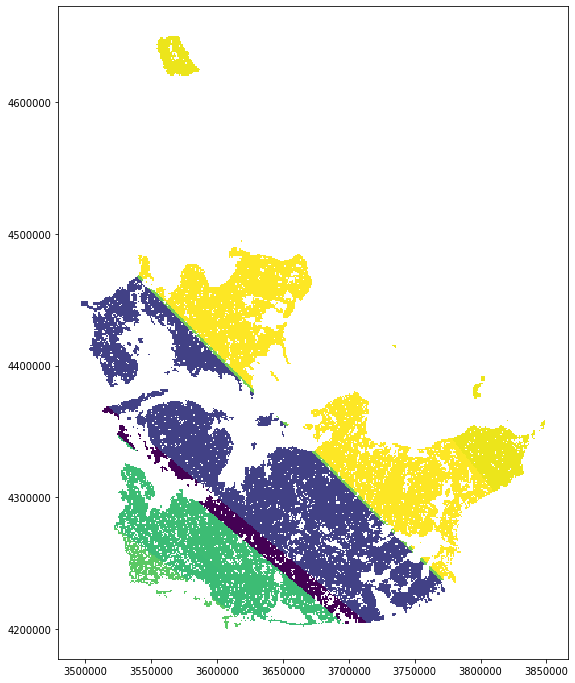

In [367]:
# plot

f, ax = plt.subplots(1, figsize=(12, 12))
ax = square_gdf.plot(column='pred',ax=ax)
plt.show()



In [329]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='longtitude', y='latitude', dist=1000, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

In [388]:
Pop_gdf = Pop_gdf.to_crs(epsg=3035)
square_df = pd.DataFrame(data = Pop_gdf, columns=['latitude','longtitude'])
square_gdf = cell_coords_to_polygons(square_df)
kommuner = kommuner.to_crs(epsg=3035)



In [391]:
square_gdf


,latitude,longtitude,geometry
0,3623000.0,4468000.0,"POLYGON ((3623000.000 4468000.000, 3624000.000..."
1,3623000.0,4469000.0,"POLYGON ((3623000.000 4469000.000, 3624000.000..."
2,3623000.0,4470000.0,"POLYGON ((3623000.000 4470000.000, 3624000.000..."
3,3624000.0,4468000.0,"POLYGON ((3624000.000 4468000.000, 3625000.000..."
4,3624000.0,4469000.0,"POLYGON ((3624000.000 4469000.000, 3625000.000..."
...,...,...,...
39002,3833000.0,4337000.0,"POLYGON ((3833000.000 4337000.000, 3834000.000..."
39003,3833000.0,4338000.0,"POLYGON ((3833000.000 4338000.000, 3834000.000..."
39004,3833000.0,4339000.0,"POLYGON ((3833000.000 4339000.000, 3834000.000..."
39005,3833000.0,4340000.0,"POLYGON ((3833000.000 4340000.000, 3834000.000..."


In [ ]:


y = cols[['price_area']]
    
# initialize KN

KN = KNeighborsRegressor()
    
# fit

KN.fit(X,y)
    
# predict on shifted lat long

preds = KN.predict(square_df[['e_shifted', 'n_shifted']])
# create new column with log10(preds) in given year
    
square_df['p_'+str(year)] = np.log10(preds)

,KOMKODE,KOMNAVN,geometry
0,0766,Hedensted,"POLYGON Z ((528116.000 6190641.000 -999.000, 5..."
1,0766,Hedensted,"POLYGON Z ((566517.000 6188004.430 -999.000, 5..."
2,0561,Esbjerg,"POLYGON Z ((474537.000 6154409.000 -999.000, 4..."
3,0849,Jammerbugt,"POLYGON Z ((547480.000 6325805.000 -999.000, 5..."
4,0849,Jammerbugt,"POLYGON Z ((511946.000 6332841.000 -999.000, 5..."
...,...,...,...
306,0461,Odense,"POLYGON Z ((579566.000 6144852.000 -999.000, 5..."
307,0563,Fanø,"POLYGON Z ((463609.000 6134156.000 -999.000, 4..."
308,0563,Fanø,"POLYGON Z ((466675.000 6133266.000 -999.000, 4..."
309,0630,Vejle,"POLYGON Z ((507350.000 6180119.000 -999.000, 5..."


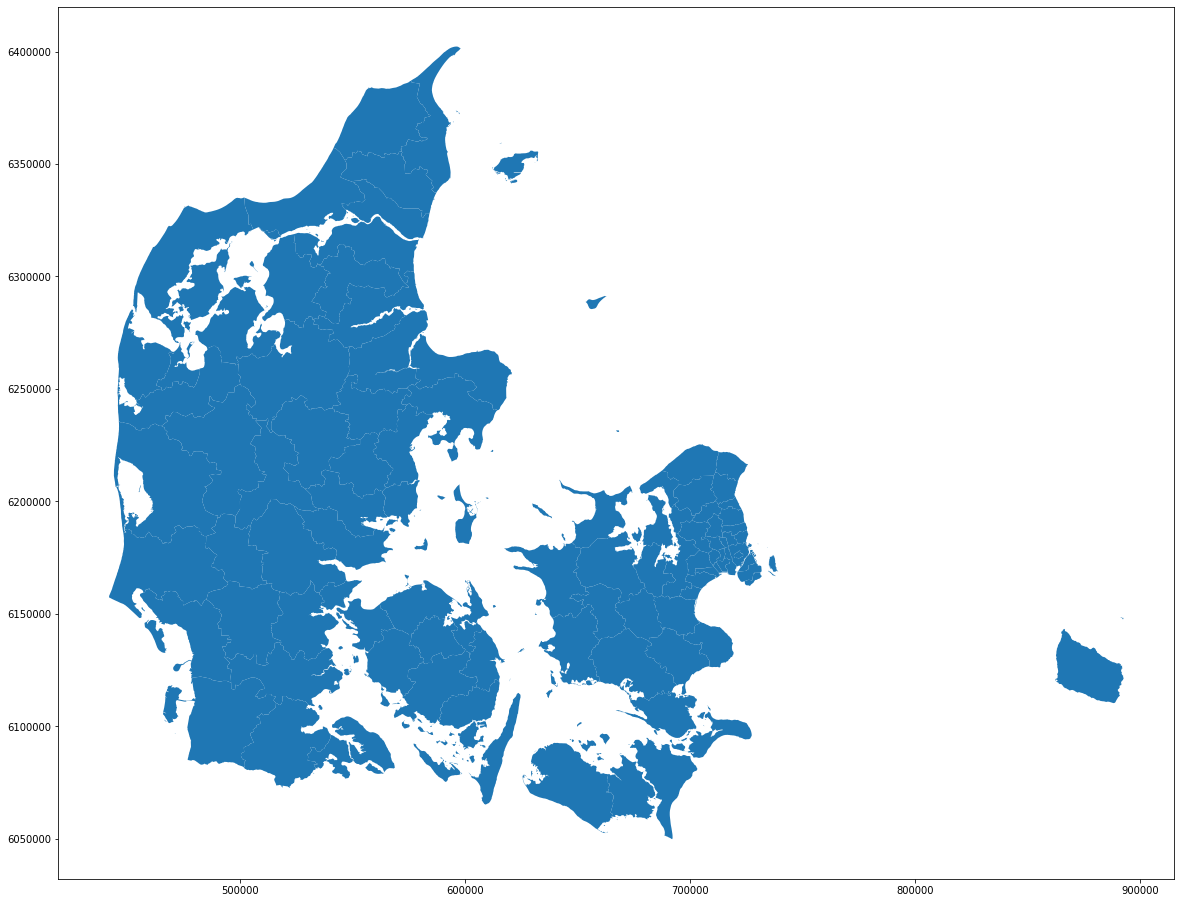

In [317]:
Kort = kommuner.plot(figsize=(20,20))
kommuner


Jeg forsøger nu at danne et grid af små områder, til at opdele kortet. 